In [1]:
import pandas as pd
import numpy as np
import random

import statsmodels.api as sm

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import matplotlib

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from ts_eval.viz import metrics as mtx
from ts_eval.viz import time_slices
from ts_eval.viz.api import TSMetrics
from ts_eval.viz.data_containers import xr_2d_factory
from ts_eval.models.naive import snaive_pi
from ts_eval.forecast_strategy.naive import NaiveForecastStrategy, SNaiveForecastStrategy
from ts_eval.forecast_strategy.sm import SMForecastStrategy
from ts_eval.utils import create_sliding_dataset


from ts_eval.utils import seasonality, trend


np.random.seed(0)
matplotlib.rcParams['figure.figsize'] = (14, 4)

# Data 

Let's create some fake data first. It should contain trend, double seasonality and some noise.

In [2]:
level = 50
n = 1400
period1 = 24
period2 = 24*7
H = 24
train_test_split_idx = 1000

ts = (level +
      trend(n, steepness=0.9) +
      seasonality(n, period1) +
      seasonality(n, period2))

sd = datetime(2019,2,1,0,0,0)

ts = pd.DataFrame(ts, index=pd.date_range(start=sd, end=sd + timedelta(days=ts.shape[0]-1), freq='1d'))

ts_train, ts_test = ts.iloc[:train_test_split_idx], ts.iloc[train_test_split_idx:]


ts_train.shape, ts_test.shape

((1000, 1), (400, 1))

Here's what the data looks like. A slight upward trend can be observed.

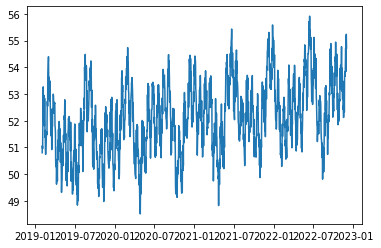

In [3]:
plt.plot(ts, linestyle='-');

# Baseline

As we know, the data contains double seasonality. Still, let's compute both naive and snaive forecasts using a helper function:

In [4]:
naive = NaiveForecastStrategy(ts, train_test_split_index=train_test_split_idx, freq=1).forecast(h=H).xarray()
snaive = SNaiveForecastStrategy(ts, train_test_split_index=train_test_split_idx, freq=24).forecast(h=H).xarray()

naive.mean_.shape, snaive.mean_.shape

((400, 24), (400, 24))

In [5]:
target = xr_2d_factory(create_sliding_dataset(ts_test, h=H).squeeze(), 
                       start_date=ts_test.index[0], 
                       freq=ts_test.index.freq)

target.mean_.shape

(400, 24)

Just for the sake of demonstration, let's compare naive and snaive forecasts for out dataset:


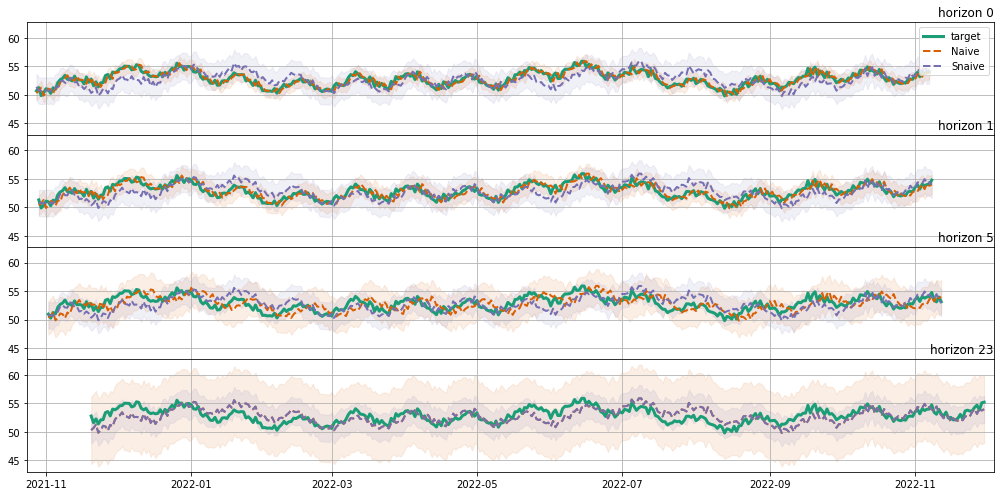

In [6]:
(TSMetrics(target, naive, snaive)
.for_horizons(0, 1, 5, 23)
.for_time_slices(time_slices.all, time_slices.weekend)
.with_description()
.with_metrics(mtx.MSE, mtx.MIS)
.with_predictions_plot()
.show())

Of course, snaive forecast is much better. Let's set it as a baseline.

# SARIMAX Basic Model

Now we can use something more advanced. Let's assume we already did some kind of model properties selection (either AIC/BIC based, or CV/validation based).

So our model is SARIMAX(2, 1, 1)x(1, 0, 1, 24).

In [7]:
SARIMAX_DEF = {"order": (2, 1, 1), "seasonal_order": (1,0,1,24)}
model = sm.tsa.SARIMAX(ts_train, **SARIMAX_DEF)
model_fit = model.fit()

/Users/vshulyak/.local/share/virtualenvs/ts-eval-VPVj6ULy/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/vshulyak/.local/share/virtualenvs/ts-eval-VPVj6ULy/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [8]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  0   No. Observations:                 1000
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 24)   Log Likelihood                -733.445
Date:                            Wed, 16 Oct 2019   AIC                           1478.889
Time:                                    14:25:27   BIC                           1508.330
Sample:                                02-01-2019   HQIC                          1490.079
                                     - 10-27-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1137      0.037     -3.090      0.002      -0.186      -0.042
ar.L2         -0.0737      0.027     -2.779      0.005      -0.126      -0.022
ma.L1         -0.5637      0.039    -14.341      0.000      -0.641      -0.487
ar.S.L24       0.9996      0.001    813.454      0.000       0.997       1.002
ma.S.L24      -0.9723      0.038    -25.615      0.000      -1.047      -0.898
sigma2         0.2380      0.014     17.078      0.000       0.211       0.265
===================================================================================
Ljung-Box (Q):                       75.34   Jarque-Bera (JB):                 3.15
Prob(Q):                              0.00   Prob(JB):                         0.21
Heteroskedasticity (H):               0.84   Skew:                             0.07
Prob(H) (two-sided):                  0.12   Kurtosis:                         2.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Now we can apply sliding window strategy and update the model using kalman filter smoothing:

In [9]:
sm_seas = SMForecastStrategy(model_fit, SARIMAX_DEF).forecast(
    ts_test, test_exog=None, h=H
).xarray()

sm_seas.mean_.shape

(400, 24)

In [10]:
SARIMAX_DEF = {"order": (2, 1, 1)}
model = sm.tsa.SARIMAX(ts_train, **SARIMAX_DEF)
model_fit = model.fit()

default = SMForecastStrategy(model_fit, SARIMAX_DEF).forecast(
    ts_test, test_exog=None, h=H
).xarray()

default.mean_.shape

(400, 24)

Now we can compare the model with snaive baseline:


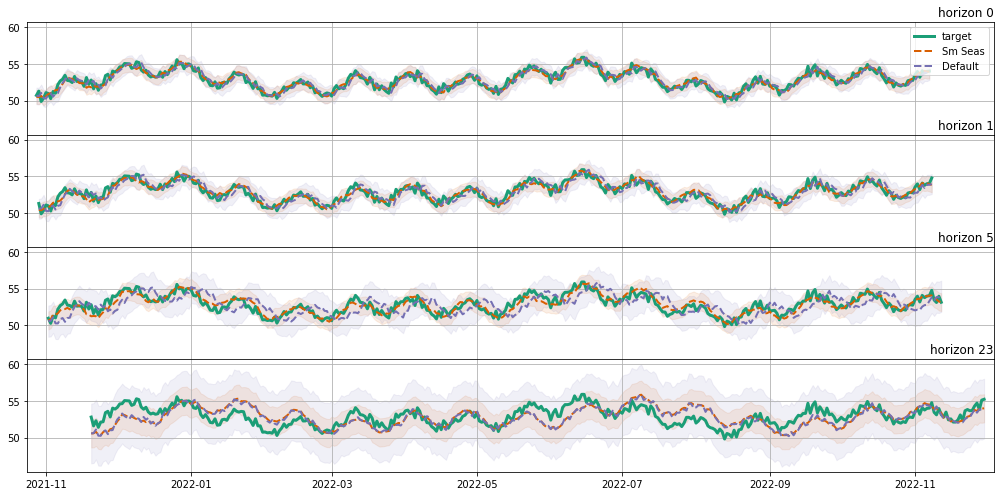

In [11]:
(
    TSMetrics(target, sm_seas, default)
    .use_reference(snaive)
    .for_horizons(0, 1, 5, 23)
    .for_time_slices(time_slices.all, time_slices.weekend)
    .with_description()
    .with_prediction_rankings(mtx.FVrMSE, mtx.FVrMIS)
    .with_predictions_plot()
    .show()
)

Clearly, overall performance for SARIMAX is better, however on point 23 the performance of naive forecast is indistinguishable from sarimax. Great, so the model can be made better! 

# SARIMAX + additional features

TODO